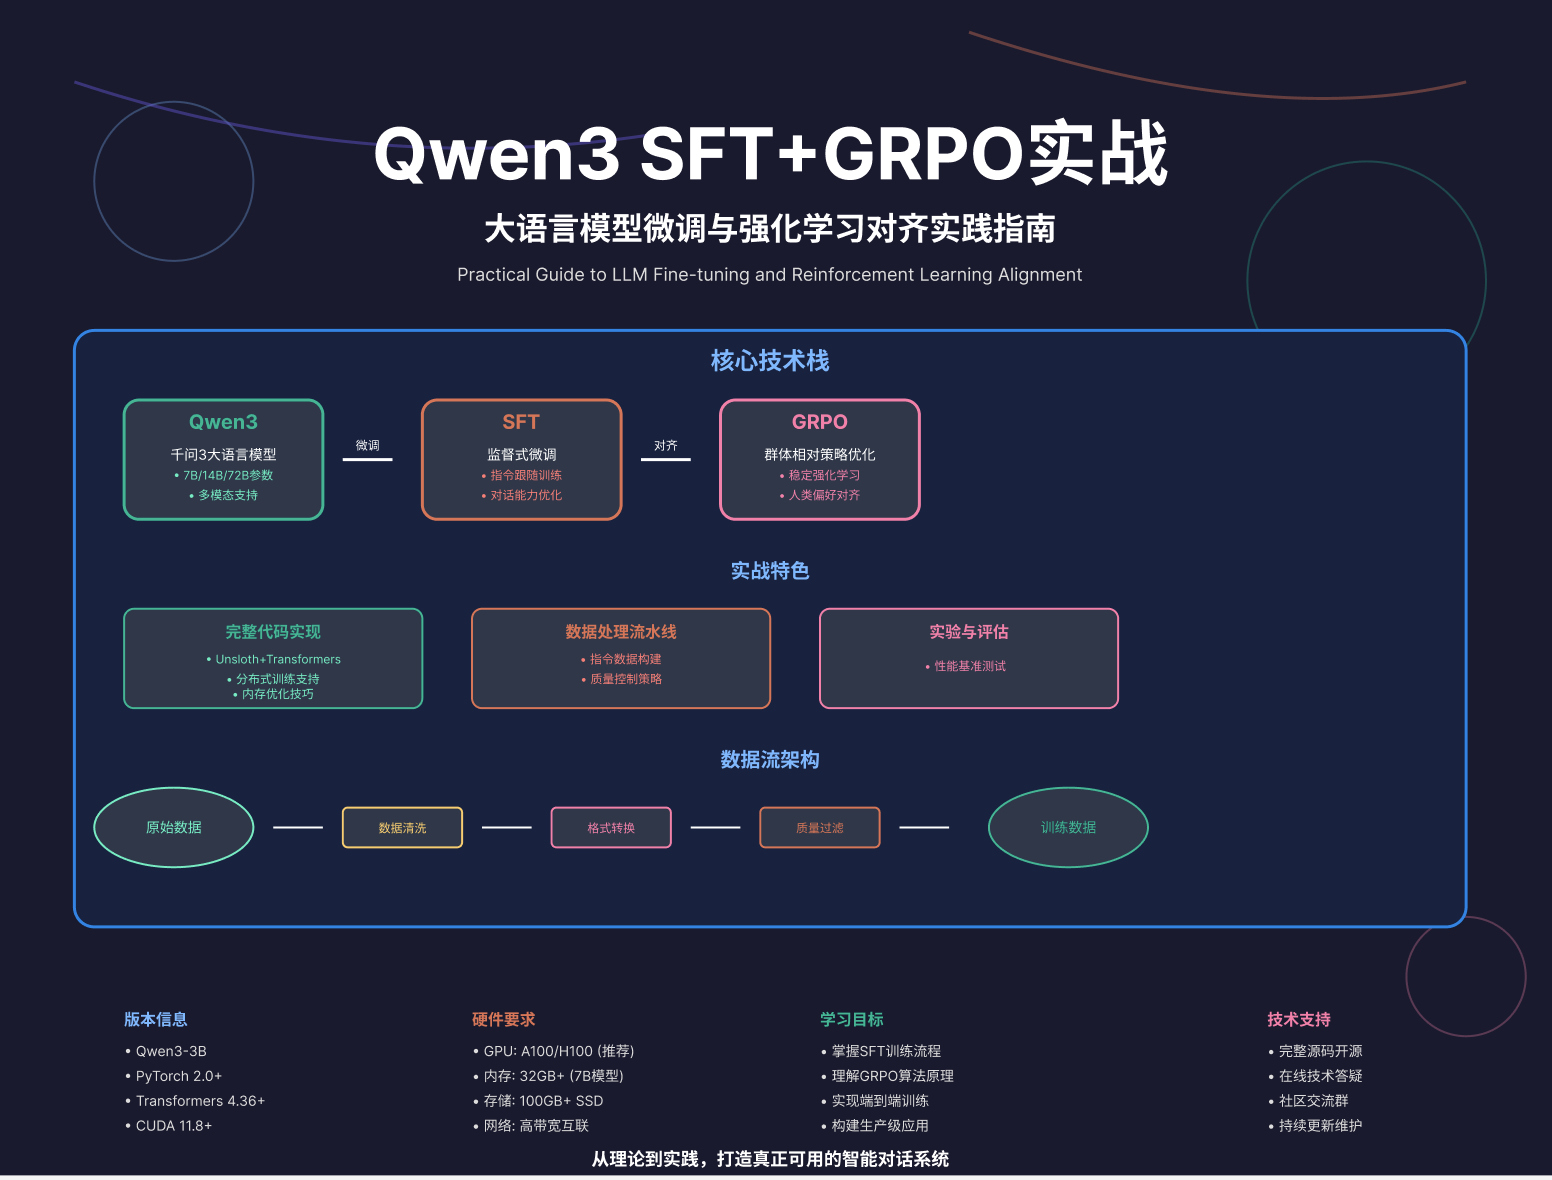

### 安装依赖

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.8.5.post1

In [3]:
#@title Colab Extra Install { display-mode: "form" }

import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


### Unsloth

目标：通过使用 OpenR1 的数学数据集，将 Qwen3-4B-Base 转换为一个推理模型，方法是使用 GRPO。

我们首先对模型进行预微调，使 GRPO 不再尝试匹配格式 —— 这样可以加快 GRPO 的训练速度。

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen3-4B-Base",
    max_seq_length = max_seq_length,
    load_in_4bit = False, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-20 11:00:39 [__init__.py:244] Automatically detected platform cuda.
==((====))==  Unsloth 2025.7.5: Fast Qwen3 patching. Transformers: 4.53.2. vLLM: 0.9.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.546 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading Qwen3-4B-Base with actual GPU utilization = 68.74%
Unsloth: Your GPU has CUDA compute capability 8.9 with VRAM = 23.55 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 224.
Unsloth: vLLM's KV Cache can use up to 9.24 GB. Also swap space = 6 GB.
I

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


INFO 07-20 11:02:06 [default_loader.py:272] Loading weights took 1.88 seconds
INFO 07-20 11:02:06 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 07-20 11:02:06 [gpu_model_runner.py:1801] Model loading took 7.6334 GiB and 2.183847 seconds
INFO 07-20 11:02:25 [backends.py:508] Using cache directory: /root/.cache/vllm/torch_compile_cache/422f2152e0/rank_0_0/backbone for vLLM's torch.compile
INFO 07-20 11:02:25 [backends.py:519] Dynamo bytecode transform time: 17.95 s


Inductor Compilation: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s, triton_poi_fused_view_6]                                     

INFO 07-20 11:02:30 [backends.py:181] Cache the graph of shape None for later use



Inductor Compilation: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4] 

INFO 07-20 11:03:27 [backends.py:193] Compiling a graph for general shape takes 60.99 s


INFO 07-20 11:05:48 [monitor.py:34] torch.compile takes 78.94 s in total
INFO 07-20 11:05:52 [gpu_worker.py:232] Available KV cache memory: 7.23 GiB
INFO 07-20 11:05:53 [kv_cache_utils.py:716] GPU KV cache size: 52,624 tokens
INFO 07-20 11:05:53 [kv_cache_utils.py:720] Maximum concurrency for 2,048 tokens per request: 25.70x


Capturing CUDA graph shapes: 100%|██████████| 67/67 [01:18<00:00,  1.17s/it]

INFO 07-20 11:07:11 [gpu_model_runner.py:2326] Graph capturing finished in 78 secs, took 0.86 GiB
INFO 07-20 11:07:11 [core.py:172] init engine (profile, create kv cache, warmup model) took 304.36 seconds


Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']
Qwen3-4B-Base does not have a padding token! Will use pad_token = <|vision_pad|>.


Unsloth 2025.7.5 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


### GRPO 聊天模板
由于我们使用的是基础模型，应该设置一个聊天模板。你也可以自定义自己的聊天模板！

DeepSeek 使用 <think> 和 </think>，但这不是必须的 —— 你可以根据需要进行自定义！

建议至少设置一个 system_prompt（系统提示词），用于引导模型的回答。

In [2]:
reasoning_start = "<start_working_out>" # Acts as <think>
reasoning_end   = "<end_working_out>"   # Acts as </think>
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = \
f"""You are given a problem.
Think about the problem and provide your working out.
Place it between {reasoning_start} and {reasoning_end}.
Then, provide your solution between {solution_start}{solution_end}"""
system_prompt

'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>'

我们在下面创建了一个简单的聊天模板。请注意，add_generation_prompt 包含了在生成提示前添加 <start_working_out>，用于引导模型开始其推理过程。

In [3]:
chat_template = \
    "{% if messages[0]['role'] == 'system' %}"\
        "{{ messages[0]['content'] + eos_token }}"\
        "{% set loop_messages = messages[1:] %}"\
    "{% else %}"\
        "{{ '{system_prompt}' + eos_token }}"\
        "{% set loop_messages = messages %}"\
    "{% endif %}"\
    "{% for message in loop_messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ message['content'] }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ message['content'] + eos_token }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}{{ '{reasoning_start}' }}"\
    "{% endif %}"

# Replace with out specific template:
chat_template = chat_template\
    .replace("'{system_prompt}'",   f"'{system_prompt}'")\
    .replace("'{reasoning_start}'", f"'{reasoning_start}'")
tokenizer.chat_template = chat_template

Let's see how our chat template behaves on an example:

In [4]:
tokenizer.apply_chat_template([
    {"role" : "user", "content" : "What is 1+1?"},
    {"role" : "assistant", "content" : f"{reasoning_start}I think it's 2.{reasoning_end}{solution_start}2{solution_end}"},
    {"role" : "user", "content" : "What is 2+2?"},
], tokenize = False, add_generation_prompt = True)

"You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION><|endoftext|>What is 1+1?<start_working_out>I think it's 2.<end_working_out><SOLUTION>2</SOLUTION><|endoftext|>What is 2+2?<start_working_out>"

### 格式预微调
我们现在使用 NVIDIA 的 Open Math Reasoning 数据集 的一个子集，该子集已被过滤，仅保留高质量的 DeepSeek R1 推理轨迹。

我们将仅筛选大约 59 个样本，用于“预热”/预微调模型，使其理解我们自定义的 GRPO 格式。

以下model或dataset若设置后无法加载，则直接从modelscope/huggingface拉取，路径改为储存路径即可，拉取教程见第一周课程文档

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

dataset = load_dataset("unsloth/OpenMathReasoning-mini", split = "cot")
dataset = dataset.to_pandas()[
    ["expected_answer", "problem", "generated_solution"]
]

# Try converting to number - if not, replace with NaN
is_number = pd.to_numeric(pd.Series(dataset["expected_answer"]), errors = "coerce").notnull()
# Select only numbers
dataset = dataset.iloc[np.where(is_number)[0]]

dataset

Generating cot split:   0%|          | 0/19252 [00:00<?, ? examples/s]

,expected_answer,problem,generated_solution
0,14,Given $\sqrt{x^2+165}-\sqrt{x^2-52}=7$ and $x$...,"<think>\nOkay, let's see. I need to solve the ..."
6,-2,Find the value of the parameter $a$ for which ...,"<think>\nOkay, so I need to find the value of ..."
9,18,What is the sum of all real numbers $x$ for wh...,"<think>\nOkay, so I need to solve the equation..."
13,2,Evaluate the sum \(\sum_{n=1}^\infty \frac{\ph...,"<think>\nOkay, so I need to evaluate the infin..."
17,30,What is the largest positive integer that divi...,"<think>\nAlright, so I need to find the larges..."
...,...,...,...
19243,244,"Let \( p \), \( q \), and \( r \) be the disti...","<think>\nOkay, so I need to find the value of ..."
19245,1,A bug is on the $0$ of a number line. At any p...,"<think>\nOkay, so I have this problem where a ..."
19247,4,A bus left point X for point Y. Two hours late...,"<think>\nOkay, let's tackle this problem step ..."
19248,18,Each interior angle of a regular n-gon measure...,"<think>\nOkay, let's see. I need to find the n..."


In [6]:
def format_dataset(x):
    expected_answer = x["expected_answer"]
    problem = x["problem"]

    # Remove generated <think> and </think>
    thoughts = x["generated_solution"]
    thoughts = thoughts.replace("<think>", "").replace("</think>", "")

    # Strip newlines on left and right
    thoughts = thoughts.strip()
    # Add our custom formatting
    final_prompt = \
        reasoning_start + thoughts + reasoning_end + \
        solution_start + expected_answer + solution_end
    return [
        {"role" : "system",    "content" : system_prompt},
        {"role" : "user",      "content" : problem},
        {"role" : "assistant", "content" : final_prompt},
    ]

dataset["Messages"] = dataset.apply(format_dataset, axis = 1)

我们看一下效果

In [7]:
tokenizer.apply_chat_template(dataset["Messages"][0], tokenize = False)

"You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Given $\\sqrt{x^2+165}-\\sqrt{x^2-52}=7$ and $x$ is positive, find all possible values of $x$.<start_working_out>Okay, let's see. I need to solve the equation √(x² + 165) - √(x² - 52) = 7, and find all positive values of x. Hmm, radicals can be tricky, but maybe if I can eliminate the square roots by squaring both sides. Let me try that.\n\nFirst, let me write down the equation again to make sure I have it right:\n\n√(x² + 165) - √(x² - 52) = 7.\n\nOkay, so the idea is to isolate one of the radicals and then square both sides. Let me try moving the second radical to the other side:\n\n√(x² + 165) = 7 + √(x² - 52).\n\nNow, if I square both sides, maybe I can get rid of the square roots. Let's do that:\n\n(√(x² + 165))² = (7 + √(x² - 52))².\n\nSimplifying the left side:\n\nx² + 

我们把长度大于1/2最大长度的过滤掉，为了节约资源

In [8]:
dataset["N"] = dataset["Messages"].apply(lambda x: len(tokenizer.apply_chat_template(x)))

dataset = dataset.loc[dataset["N"] <= max_seq_length/2].copy()
dataset.shape

(59, 5)

然后我们token化数据集并且转化为hf的数据集格式

In [9]:
from datasets import Dataset

dataset["text"] = tokenizer.apply_chat_template(dataset["Messages"].values.tolist(), tokenize = False)
dataset = Dataset.from_pandas(dataset)
dataset

Dataset({
    features: ['expected_answer', 'problem', 'generated_solution', 'Messages', 'N', 'text', '__index_level_0__'],
    num_rows: 59
})

开始微调！

In [10]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 2, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/59 [00:00<?, ? examples/s]

In [11]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 59 | Num Epochs = 2 | Total steps = 118
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Step,Training Loss
5,0.655100
10,0.657700
15,0.424400
20,0.392600
25,0.424600
30,0.452600
35,0.474800
40,0.419800
45,0.446600
50,0.335700


Unsloth: Will smartly offload gradients to save VRAM!


TrainOutput(global_step=118, training_loss=0.35135028574426297, metrics={'train_runtime': 58.6978, 'train_samples_per_second': 2.01, 'train_steps_per_second': 2.01, 'total_flos': 2374193075607552.0, 'train_loss': 0.35135028574426297})

我们看一下微调的效果

In [12]:
text = tokenizer.apply_chat_template(
    dataset[0]["Messages"][:2],
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    temperature = 0,
    max_new_tokens = 1024,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)

You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Jenifer has 82 cents in pennies and nickels. Her younger brother mistook all her nickels for dimes and counted the total as $1.47. How many pennies does Jenifer have?<start_working_out>Okay, let's see. Jenifer has 82 cents in pennies and nickels. Her brother thought all the nickels were dimes and counted the total as $1.47. I need to find out how many pennies she has. Hmm, let's break this down.

First, I need to set up some equations. Let's say the number of pennies is P and the number of nickels is N. Since pennies are worth 1 cent each and nickels are 5 cents each, the total value in cents is 1P + 5N = 82. That's the first equation.

Now, her brother thought all the nickels were dimes. Dimes are 10 cents each. So, he counted the total as $1.47, which is 147 cents. So, the equat

In [ ]:
del dataset
torch.cuda.empty_cache()
import gc
gc.collect()

### 数据准备
<a name="Data"></a>

我们用 Hugging Face's [Open R1 Math dataset](https://huggingface.co/datasets/open-r1/DAPO-Math-17k-Processed). You can also utilize OpenAI's famous [GSM8K dataset](https://huggingface.co/datasets/openai/gsm8k)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("open-r1/DAPO-Math-17k-Processed", "en", split = "train")
dataset

Generating train split:   0%|          | 0/14116 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'solution', 'data_source', 'source_prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 14116
})

Let's look at the first row:

In [18]:
dataset[0]["prompt"]

'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.'

In [19]:
dataset[0]["solution"]

'34'

In GSM8K, ee notice all answers like about have a ####, so we extract it. But for the Open R1 dataset, we can skip the below.

In [20]:
def extract_hash_answer(text):
    # if "####" not in text: return None
    # return text.split("####")[1].strip()
    return text
extract_hash_answer(dataset[0]["solution"])

'34'

Let's map the dataset! and see the first row:

In [21]:
dataset = dataset.map(lambda x: {
    "prompt" : [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": x["prompt"]},
    ],
    "answer": extract_hash_answer(x["solution"]),
})
dataset[0]

Map:   0%|          | 0/14116 [00:00<?, ? examples/s]

{'prompt': [{'content': 'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>',
   'role': 'system'},
  {'content': 'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.',
   'role': 'user'}],
 'solution': '34',
 'data_source': 'math_dapo',
 'source_prompt': [{'content': 'Solve the following math problem step by step. The last line of your response should be of the form Answer: $Answer (without quotes) where $Answer is the answer to the problem.\n\nIn triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $

用正则来提取答案:

In [22]:
import re

# Add optional EOS token matching
solution_end_regex = r"</SOLUTION>[\s]{0,}" + \
    "(?:" + re.escape(tokenizer.eos_token) + ")?"

match_format = re.compile(
    rf"{reasoning_end}.*?"\
    rf"{solution_start}(.+?){solution_end_regex}"\
    rf"[\s]{{0,}}$",
    flags = re.MULTILINE | re.DOTALL
)
match_format

re.compile(r'<end_working_out>.*?<SOLUTION>(.+?)</SOLUTION>[\s]{0,}(?:<\|endoftext\|>)?[\s]{0,}$',
           re.MULTILINE|re.DOTALL|re.UNICODE)

We verify it works:

In [23]:
match_format.findall(
    "Let me think!<end_working_out>"\
    f"<SOLUTION>\n2\n</SOLUTION>",
)

['\n2\n']

In [24]:
match_format.findall(
    "<start_working_out>Let me think!<end_working_out>"\
    f"<SOLUTION>  2  </SOLUTION>\n\n",
)

['  2  ']

We now want to create a reward function to match the format exactly - we reward it with 3 points if it succeeds:

In [25]:
def match_format_exactly(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Match if format is seen exactly!
        if match_format.search(response) is not None: score += 3.0
        scores.append(score)
    return scores

If it fails, we want to reward the model if it at least follows the format partially, by counting each symbol:

In [26]:
def match_format_approximately(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Count how many keywords are seen - we penalize if too many!
        # If we see 1, then plus some points!

        # No need to reward <start_working_out> since we always prepend it!
        # score += 0.5 if response.count(reasoning_start) == 1 else -1.0
        score += 0.5 if response.count(reasoning_end)   == 1 else -1.0
        score += 0.5 if response.count(solution_start)  == 1 else -1.0
        score += 0.5 if response.count(solution_end)    == 1 else -1.0
        scores.append(score)
    return scores

In [27]:
def check_answer(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_format.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        score = 0
        if guess is None:
            scores.append(-2.0)
            continue
        # Correct answer gets 5 points!
        if guess == true_answer:
            score += 5.0
        # Match if spaces are seen, but less reward
        elif guess.strip() == true_answer.strip():
            score += 3.5
        else:
            # We also reward it if the answer is close via ratios!
            # Ie if the answer is within some range, reward it!
            try:
                ratio = float(guess) / float(true_answer)
                if   ratio >= 0.9 and ratio <= 1.1: score += 2.0
                elif ratio >= 0.8 and ratio <= 1.2: score += 1.5
                else: score -= 2.5 # Penalize wrong answers
            except:
                score -= 4.5 # Penalize
        scores.append(score)
    return scores

这个 `check_answer` 函数的评分逻辑用于评估模型生成的答案（`completions`）与真实答案（`answer`）之间的匹配程度，其核心逻辑如下：

---

### 总体流程：

1. 获取提问内容（主要用于定位任务）。
2. 提取模型回答中匹配格式的部分（通过 `match_format` 正则表达式）。
3. 将提取出的回答与真实答案进行对比，打分。
4. 返回每个样本的得分列表 `scores`。

---

### 每个回答的评分标准：

#### 1. 完全正确：

```python
if guess == true_answer:
    score += 5.0
```

* 模型输出与标准答案完全相同（包括空格），得 **5 分**。

#### 2. 去掉空格后匹配：

```python
elif guess.strip() == true_answer.strip():
    score += 3.5
```

* 答案在去除前后空格后匹配，得 **3.5 分**（容错空间更大，格式不要求严格）。

#### 3. 数值接近：

```python
ratio = float(guess) / float(true_answer)
```

* 如果是数值型答案（如数学题），会判断其相对误差：

| 相对误差范围      | 分数   |
| ----------- | ---- |
| 90% \~ 110% | +2.0 |
| 80% \~ 120% | +1.5 |
| 超出此范围       | -2.5 |

#### 4. 非法值或完全错误：

```python
if guess is None:
    scores.append(-2.0)
except:
    score -= 4.5
```

* 如果正则匹配失败或无法转换为数值，说明答案格式错误，扣 **2.0 到 4.5 分不等**。

---

### 🔚 输出：

返回一个列表 `scores`，每个元素对应一个样本的得分。

---

### ✅ 示例总结：

| 模型输出        | 真实答案   | 得分说明      | 分数   |
| ----------- | ------ | --------- | ---- |
| `"42"`      | `"42"` | 完全匹配      | 5.0  |
| `" 42 "`    | `"42"` | 空格容忍匹配    | 3.5  |
| `"43"`      | `"42"` | 相对误差 <10% | 2.0  |
| `"50"`      | `"42"` | 相对误差 <20% | 1.5  |
| `"100"`     | `"42"` | 相对误差太大    | -2.5 |
| `"abc"`     | `"42"` | 无法转换为数值   | -4.5 |
| `None`（未提取） | `"42"` | 无结果/正则没匹配 | -2.0 |


In [28]:
match_numbers = re.compile(
    solution_start + r".*?[\s]{0,}([-]?[\d\.\,]{1,})",
    flags = re.MULTILINE | re.DOTALL
)
print(match_numbers.findall("<SOLUTION>  0.34  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>  123,456  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>  -0.234  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>17</SOLUTION>"))

['0.34']
['123,456']
['-0.234']
['17']


我们现在准备主函数，它将打印出生成的回复和真实答案。同时，还会准备另一个奖励函数，该函数通过 float 将文本转换为浮点数，并判断其是否相同。

In [29]:
global PRINTED_TIMES
PRINTED_TIMES = 0
global PRINT_EVERY_STEPS
PRINT_EVERY_STEPS = 5

def check_numbers(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_numbers.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    # Print only every few steps
    global PRINTED_TIMES
    global PRINT_EVERY_STEPS
    if PRINTED_TIMES % PRINT_EVERY_STEPS == 0:
        print(
            '*'*20 + f"Question:\n{question}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}"
        )
    PRINTED_TIMES += 1

    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(-2.5)
            continue
        # Convert to numbers
        try:
            true_answer = float(true_answer.strip())
            # Remove commas like in 123,456
            guess       = float(guess.strip().replace(",", ""))
            scores.append(3.5 if guess == true_answer else -1.5)
        except:
            scores.append(0)
            continue
    return scores

过滤了10%的长文本

In [30]:
tokenized = dataset.map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["prompt"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
print(tokenizer.decode(tokenized[0]["tokens"]))
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
dataset = dataset.select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized

Map:   0%|          | 0/14116 [00:00<?, ? examples/s]

You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION><|endoftext|>In triangle $ABC$, $\sin \angle A = \frac{4}{5}$ and $\angle A < 90^\circ$. Let $D$ be a point outside triangle $ABC$ such that $\angle BAD = \angle DAC$ and $\angle BDC = 90^\circ$. Suppose that $AD = 1$ and that $\frac{BD}{CD} = \frac{3}{2}$. If $AB + AC$ can be expressed in the form $\frac{a\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.<start_working_out>


Map:   0%|          | 0/14116 [00:00<?, ? examples/s]

Max Length =  201


<a name="Train"></a>
### Train the model

Now set up GRPO Trainer and all configurations!

In [31]:
max_prompt_length = maximum_length + 1 # + 1 just in case!
max_completion_length = max_seq_length - max_prompt_length

from vllm import SamplingParams
vllm_sampling_params = SamplingParams(
    min_p = 0.1,
    top_p = 1.0,
    top_k = -1,
    seed = 3407,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    vllm_sampling_params = vllm_sampling_params,
    temperature = 1.0,
    learning_rate = 5e-6,
    weight_decay = 0.01,
    warmup_ratio = 0.1,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 100,
    save_steps = 100,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",

    # For optional training + evaluation
    # fp16_full_eval = True,
    # per_device_eval_batch_size = 4,
    # eval_accumulation_steps = 1,
    # eval_strategy = "steps",
    # eval_steps = 1,
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


And let's run the trainer! If you scroll up, you'll see a table of rewards. The goal is to see the `reward` column increase!

You might have to wait 150 to 200 steps for any action. You'll probably get 0 reward for the first 100 steps. Please be patient!

| Step | Training Loss | reward    | reward_std | completion_length | kl       |
|------|---------------|-----------|------------|-------------------|----------|
| 1    | 0.000000      | 0.125000  | 0.000000   | 200.000000        | 0.000000 |
| 2    | 0.000000      | 0.072375  | 0.248112   | 200.000000        | 0.000000 |
| 3    | 0.000000      | -0.079000 | 0.163776   | 182.500000        | 0.000005 |


In [32]:
# For optional training + evaluation
# new_dataset = dataset.train_test_split(test_size = 0.01)

trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    args = training_args,
    train_dataset = dataset,

    # For optional training + evaluation
    # train_dataset = new_dataset["train"],
    # eval_dataset = new_dataset["test"],
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12,709 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


********************Question:
Compute the number of positive integers that divide at least two of the integers in the set $\{1^1,2^2,3^3,4^4,5^5,6^6,7^7,8^8,9^9,10^{10}\}$. 
Answer:
22 
Response:
Okay, so I need to find how many positive integers divide at least two of the numbers in this set: {1^1, 2^2, 3^3, 4^4, 5^5, 6^6, 7^7, 8^8, 9^9, 10^10}. Hmm, let's start by simplifying each of these terms. 

First, compute each number in the set:
- 1^1 = 1
- 2^2 = 4
- 3^3 = 27
- 4^4 = 256
- 5^5 = 3125
- 6^6 = 46656
- 7^7 = 823543
- 8^8 = 16777216
- 9^9 = 387420489
- 10^10 = 10000000000

Wait, so these are all very large numbers except for the first few. The problem is asking for the number of positive integers that divide at least two of these. Let me think. Divisors that appear in multiple terms must be shared common divisors between pairs or more. So maybe I need to find all pairs, compute their greatest common divisors (GCDs), and then count the unique divisors in those GCDs.

But wait, the

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / match_format_exactly / mean,rewards / match_format_exactly / std,rewards / match_format_approximately / mean,rewards / match_format_approximately / std,rewards / check_answer / mean,rewards / check_answer / std,rewards / check_numbers / mean,rewards / check_numbers / std
1,0.000100,-7.500000,0.000000,1846.000000,1846.000000,1846.000000,1.000000,0.000000,0.000000,0.000000,0.121305,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
2,0.000200,0.500000,0.000000,1250.500000,1021.000000,1680.000000,0.000000,1250.500000,1021.000000,1680.000000,0.169433,3.000000,0.000000,1.500000,0.000000,-2.500000,0.000000,-1.500000,0.000000
3,0.000200,-7.500000,0.000000,1846.000000,1846.000000,1846.000000,1.000000,0.000000,0.000000,0.000000,0.173266,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
4,0.000100,-7.500000,0.000000,1846.000000,1846.000000,1846.000000,1.000000,0.000000,0.000000,0.000000,0.148554,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
5,0.000200,13.000000,0.000000,1000.500000,727.000000,1249.000000,0.000000,1000.500000,727.000000,1249.000000,0.185144,3.000000,0.000000,1.500000,0.000000,5.000000,0.000000,3.500000,0.000000
6,0.000100,-7.500000,0.000000,1846.000000,1846.000000,1846.000000,1.000000,0.000000,0.000000,0.000000,0.130523,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
7,0.000100,-7.500000,0.000000,1846.000000,1846.000000,1846.000000,1.000000,0.000000,0.000000,0.000000,0.138468,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
8,0.000100,-2.375000,10.250000,1760.750000,1505.000000,1846.000000,0.750000,1505.000000,1505.000000,1505.000000,0.116602,0.750000,1.500000,-1.875000,2.250000,-0.250000,3.500000,-1.000000,3.000000
9,0.000100,-4.500000,6.000000,1800.250000,1663.000000,1846.000000,0.750000,1663.000000,1663.000000,1663.000000,0.140194,0.750000,1.500000,-1.875000,2.250000,-1.125000,1.750000,-2.250000,0.500000
10,0.000100,-7.500000,0.000000,1846.000000,1846.000000,1846.000000,1.000000,0.000000,0.000000,0.000000,0.106519,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000


********************Question:
The sum of $\lfloor x \rfloor$ for all real numbers $x$ satisfying the equation $16 + 15x + 15x^2 = \lfloor x \rfloor^3$ is: 
Answer:
33 
Response:
Okay, let's see. I need to find the sum of floor x for all real x that satisfy the equation 16 + 15x + 15x² = floor(x)³. Hmm, floor(x) is the greatest integer less than or equal to x. So, maybe I can think of x as being between two integers, n and n+1, where n is an integer. Then floor(x) is n. So, substituting that into the equation gives 16 + 15x + 15x² = n³. Since n is an integer, maybe I can find integer solutions for n and then check if there are corresponding x in the interval [n, n+1).

Let me try some integer values for n. Starting with n = 0. Then the equation becomes 16 + 15x + 15x² = 0. But that's a quadratic in x. Solving 15x² + 15x + 16 = 0. The discriminant is 15² - 4*15*16 = 225 - 960 = -735, which is negative. So no real solutions here. Thus, n can't be 0.

Next, n = 1. Then 16 + 15x + 15x² = 1,

TrainOutput(global_step=100, training_loss=0.00014972053952078568, metrics={'train_runtime': 2977.0365, 'train_samples_per_second': 0.134, 'train_steps_per_second': 0.034, 'total_flos': 0.0, 'train_loss': 0.00014972053952078568})

<a name="Inference"></a>
### Inference
Now let's try the model we just trained! First, let's first try the model without any GRPO trained:

In [ ]:
text = "What is the sqrt of 101?"

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

' - Answers\nEducation\nMath and Arithmetic\nWhat is the sqrt of 101?\nWiki User\n∙ 2009-06-05 01:02:40\nBest Answer\nCopy\n10.05\nWiki User\n∙ 2009-06-05 01:02:40\nThis answer is:\n🙏\n0\n🤨\n0\n😮\n0\nWhat is the sqrt of 100?\nThe square root of 100 is 10; 10x10=100\nWhat is the Sqrt of 100?\nSqrt (100) = +10 &amp; -10 since both (+10) X (+10) and (-10) X (-\n10) equal 100\nWhat is the sqrt of 10000?\nIt is 100.\nHow many meters in a kilometer?\nThere are 1000 meters in a kilometer. 100 centimeter in a\nmeter. 1,000 meters in a km. 100cm in a meter.\nThe square root 100 is?\n-10 +10\nSqrt x equals 7 sqrt 2 find the value of x?\nSqrt(x) = 7 Sqrt(2) x = 72 x 2 x = 49 x 2 x = 98\nSqrt 100 simplified?\nSqrt(100) = 10 is its simplest form.\nWhat is the sqr root of 100?\n10 or -10 because 10*10=100\nand (-10)(-10)=100\nSqr\'s and cubs?\nSqrt(100) = 10 and 102 = 100Sqrt(1000) = 31.6 and 31.62 = 10001Sqrt(24) = 4.9 and 4.92 = 24If you are unsure, just check them out by calculator.The "cube" of 

And now with the LoRA we just trained with GRPO - we first save the LoRA first!

In [33]:
model.save_lora("grpo_saved_lora")

Verify LoRA is actually trained!

In [34]:
from safetensors import safe_open

tensors = {}
with safe_open("grpo_saved_lora/adapter_model.safetensors", framework = "pt") as f:
    # Verify both A and B are non zero
    for key in f.keys():
        tensor = f.get_tensor(key)
        n_zeros = (tensor == 0).sum() / tensor.numel()
        assert(n_zeros.item() != tensor.numel())

Now we load the LoRA and test:

In [38]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "What is the sqrt of 101?"},
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)
from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 2048,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

"Okay, let's try to figure out the square root of 101. Hmm, I remember that square roots are the opposite of squaring numbers. So, if I can find a number that when multiplied by itself gives 101, that's the square root. But wait, what's the closest perfect square around 101?\n\nLet me think. 10^2 is 100, and 11^2 is 121. So, the square root of 101 is between 10 and 11. Since 101 is closer to 100 than to 121, maybe the square root is a bit more than 10. Let me try 10.05. Wait, is that a good guess? Let me calculate 10.05 squared.\n\n10.05 × 10.05. Let me break that down. 10 × 10 = 100, 10 × 0.05 = 0.5, 0.05 × 10 = 0.5, and 0.05 × 0.05 = 0.0025. Adding those up: 100 + 0.5 + 0.5 + 0.0025 = 101.0025. That's a little over 101. So, maybe 10.05 is too high. How about 10.04? Let me check 10.04 squared.\n\n10.04 × 10.04 is (10 + 0.04)^2 = 100 + 2*10*0.04 + 0.04^2. Calculate that: 2*10*0.04 is 0.8, and 0.04^2 is 0.0016. So total is 100 + 0.8 + 0.0016 = 100.8016. That's a bit low. So the square r

可以看出，在经过了grpo之后的模型表现更好